# A Notebook showcasing the NTS-UK 2017 travel patterns and Simulated EV demand across years and seasons.

### Importing Libraries & Root folder

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import EVforecaster.config as cfg
import numpy as np

dataframes_folder = cfg.root_folder + "/dataframes/"
plots_folder = cfg.root_folder + "/plots/"


### Importing Data

In [2]:
nts_uk_2017 = pd.read_pickle(dataframes_folder + "/Ready_to_model_df.pkl")



In [3]:
nts_uk_2017.head()

,DayID,TripID,IndividualID,HouseholdID,TravDay,JourSeq,TripStart,TripEnd,TripDisExSW,TripStartLoc,...,TripEndRolling,TravelYear,TravelWeekDay_B01ID,TWSWeek,TripStartRolling+1,TimeEndLoc,Distance+1,WeekDayDiff,WeekRollover,TWSWeekNew
0,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,2.0,1.0,540.0,580.0,6.0,3,...,2020.0,2017,5,2,2400.0,380.0,6.0,NaN,0,2
1,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,2.0,2.0,960.0,995.0,6.0,2,...,2435.0,2017,5,2,6360.0,3925.0,4.0,0.0,0,2
2,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,5.0,1.0,600.0,620.0,4.0,3,...,6380.0,2017,1,2,6450.0,70.0,4.0,-4.0,1,3
3,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,5.0,2.0,690.0,710.0,4.0,2,...,6470.0,2017,1,2,NaN,NaN,NaN,0.0,1,3
4,2.017000e+09,2.017000e+09,2.017000e+09,2.017000e+09,1.0,1.0,480.0,545.0,22.0,3,...,545.0,2017,3,3,1020.0,475.0,22.0,NaN,0,3


## NTS-UK 2017 travel patterns

### Exploring travel patterns over the year

In [4]:
nts_uk_2017.columns

Index(['DayID', 'TripID', 'IndividualID', 'HouseholdID', 'TravDay', 'JourSeq',
       'TripStart', 'TripEnd', 'TripDisExSW', 'TripStartLoc', 'TripEndLoc',
       'TripType', 'TripStartRolling', 'TripEndRolling', 'TravelYear',
       'TravelWeekDay_B01ID', 'TWSWeek', 'TripStartRolling+1', 'TimeEndLoc',
       'Distance+1', 'WeekDayDiff', 'WeekRollover', 'TWSWeekNew'],
      dtype='object')

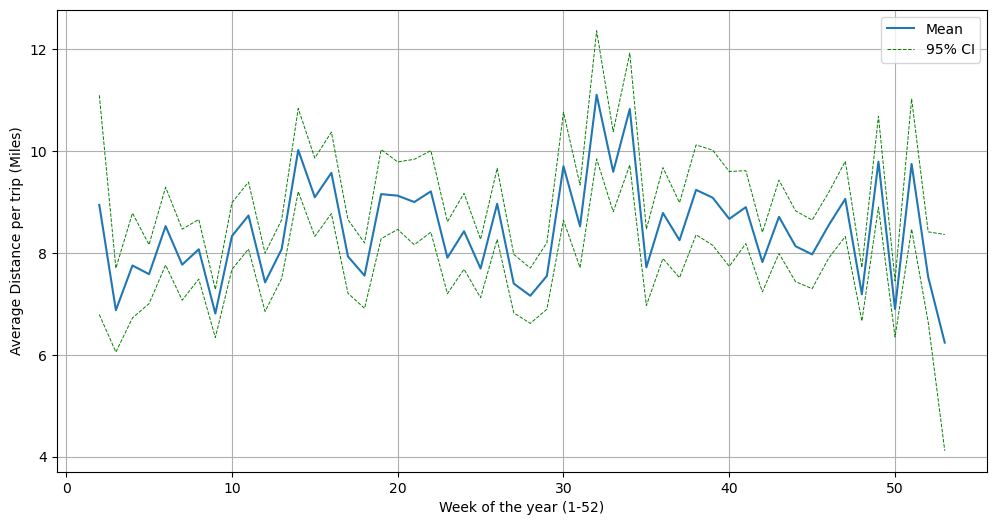

In [5]:
distance_by_week = nts_uk_2017.groupby("TWSWeek")["TripDisExSW"].agg(["mean", "std", "count"])

distance_by_week["CI"] = 1.96*distance_by_week["std"]/ np.sqrt(distance_by_week["count"])

distance_by_week["CI-"] = distance_by_week["mean"] - distance_by_week["CI"]
distance_by_week["CI+"] = distance_by_week["mean"] + distance_by_week["CI"]

x = distance_by_week.index
y = distance_by_week["mean"]
ci_plus = distance_by_week["CI+"]
ci_minus = distance_by_week["CI-"]

plt.figure(figsize=(12,6))
plt.grid()
plt.plot(x,y, label="Mean")
plt.plot(x, ci_plus, label="95% CI" , linestyle="--", color="green", linewidth=0.7)
plt.plot(x, ci_minus, linestyle="--",                 color="green", linewidth=0.7)

plt.legend()

plt.ylabel("Average Distance per trip (Miles)")
plt.xlabel("Week of the year (1-52)")

plt.savefig(plots_folder + "/weekly_trip_distance.pdf", format="pdf")


### Exploring TripType Proportions

In [6]:
triptype_vcs = nts_uk_2017.value_counts("TripType",normalize=True)

triptype_vcs.to_frame().round(3).sort_index()

,proportion
TripType,
1,0.103
2,0.097
3,0.323
4,0.322
5,0.024
6,0.020
8,0.111


### Trip Type Mapping

In [7]:
trip_type_mapping = {
    
    1:   "Home-Work",
    2:   "Work-Home",

    3:   "Home-Other",
    4:   "Other-Home",

    5:   "Work-Other",
    6:   "Other-Work",

    7:   "Home-Home",
    8:   "Other-Other",
    #"3-3": 9,   #Work-Work
}

### Plotting Distributions of TripStart and TripDisExSW across different trip types.

In [8]:
def plot_dists(df, trip_type_index, variable_index, mapping=trip_type_mapping):
    ## Comparing individual trip stats

    df = df.copy()
    df = df[df.TripType == trip_type_index]

    # Plot histogram
    #plt.figure(figsize=(7, 5))
    plt.hist(df[variable_index], bins=75, alpha=0.5, label="Real", color="blue", density=True)


    if variable_index == "TripDisExSW":
        plt.xlim(0,100)

    # Labels and legend
    plt.xlabel(f"{variable_index}")
    plt.ylabel("Density")
    plt.title(f"Histogram of {variable_index} for trip type: {mapping[trip_type_index]}.")
    plt.grid()

/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


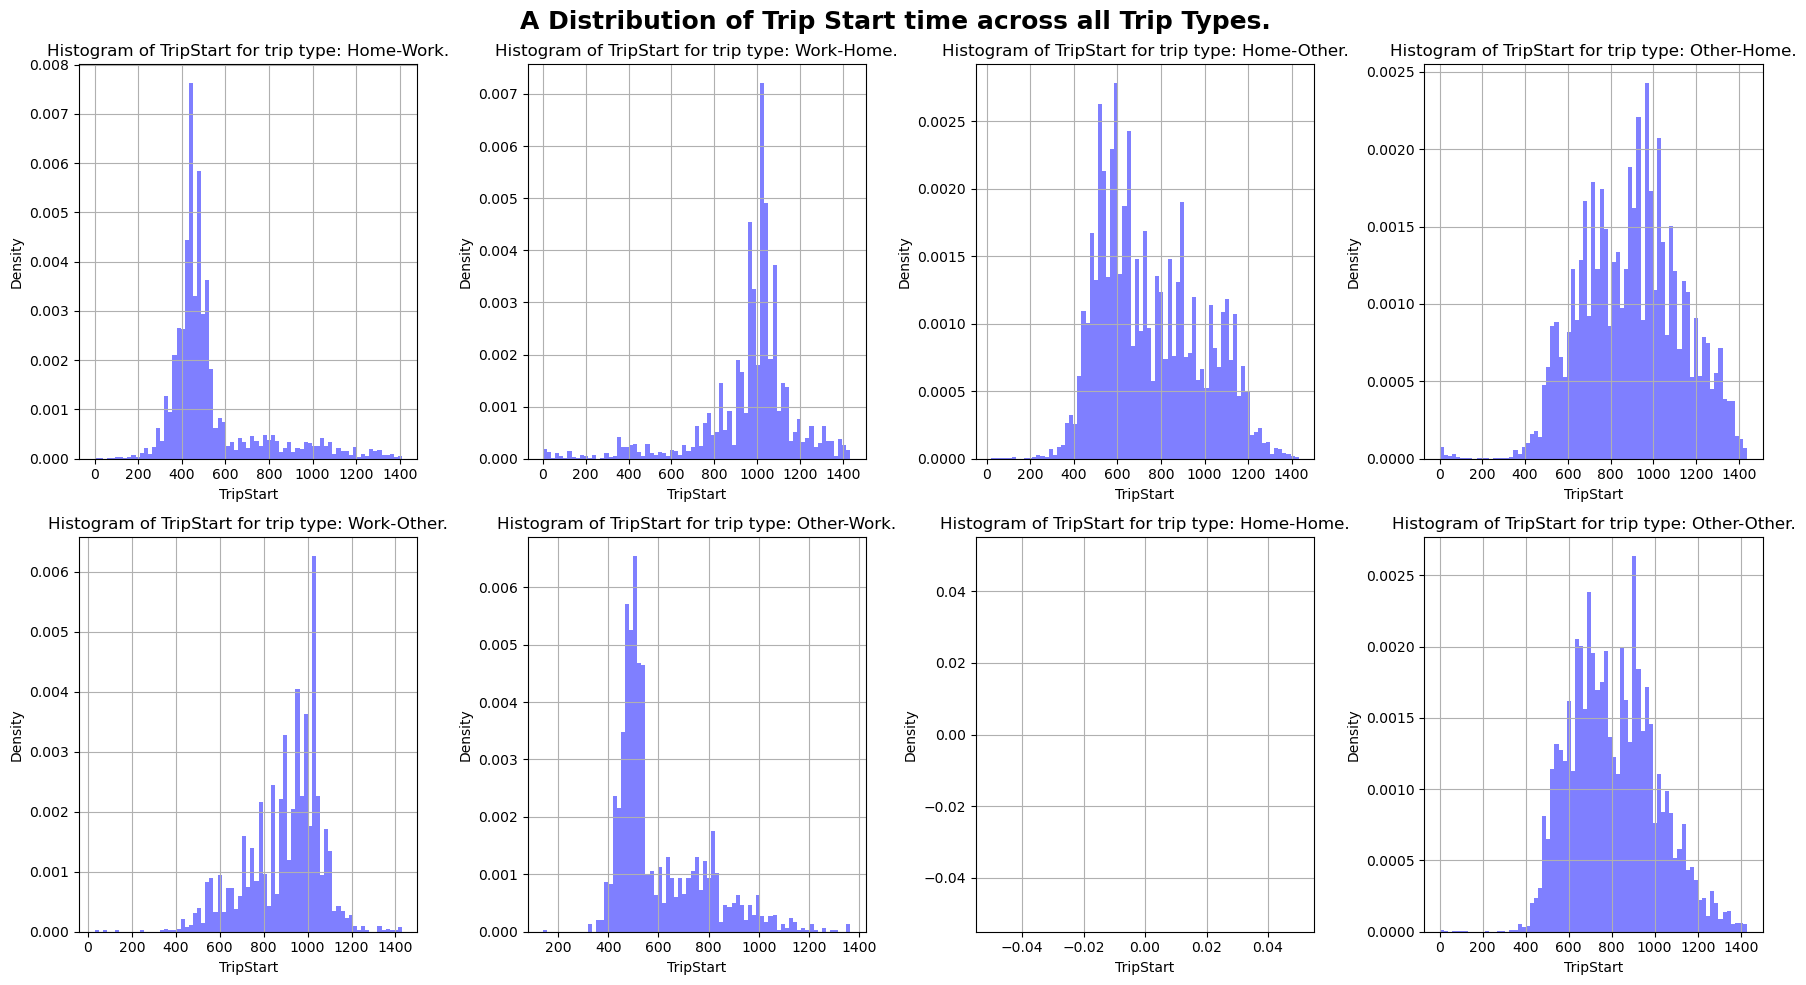

In [9]:
plt.figure(figsize=(18, 10))
# 🔹 Add an overall title
plt.suptitle("A Distribution of Trip Start time across all Trip Types.", fontsize=18, fontweight="bold")

for i in range(1,9):
    plt.subplot(2,4,i)
    plot_dists(df=nts_uk_2017, trip_type_index=i, variable_index="TripStart")


plt.tight_layout()  # Adjust layout to avoid overlap

plt.savefig(plots_folder + "/TripStartTripType.pdf", format="pdf", bbox_inches="tight")

plt.show()



/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


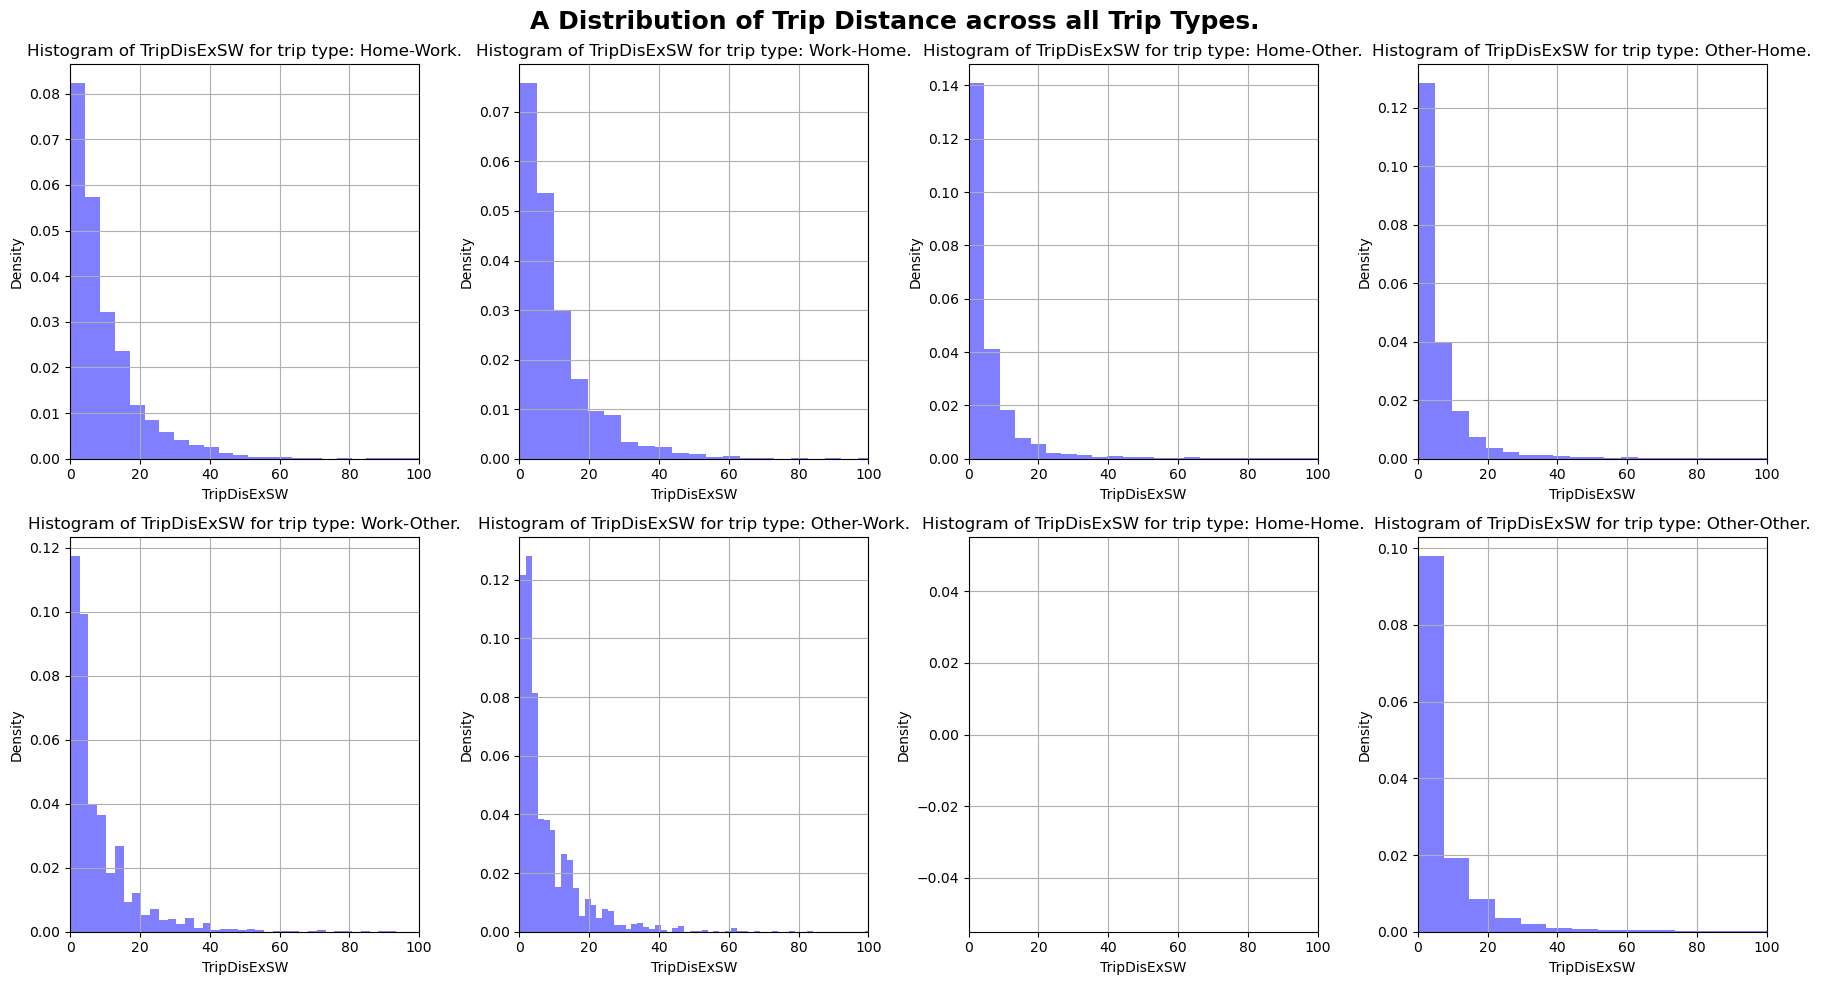

In [10]:
plt.figure(figsize=(18, 10))
# 🔹 Add an overall title
plt.suptitle("A Distribution of Trip Distance across all Trip Types.", fontsize=18, fontweight="bold")

for i in range(1,9):
    plt.subplot(2,4,i)
    plot_dists(df=nts_uk_2017, trip_type_index=i, variable_index="TripDisExSW")


plt.tight_layout()  # Adjust layout to avoid overlap

plt.savefig(plots_folder + "/DistanceTripType.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Parking Heatplot

In [64]:
nts_uk_2017.columns

Index(['DayID', 'TripID', 'IndividualID', 'HouseholdID', 'TravDay', 'JourSeq',
       'TripStart', 'TripEnd', 'TripDisExSW', 'TripStartLoc', 'TripEndLoc',
       'TripType', 'TripStartRolling', 'TripEndRolling', 'TravelYear',
       'TravelWeekDay_B01ID', 'TWSWeek', 'TripStartRolling+1', 'TimeEndLoc',
       'Distance+1', 'WeekDayDiff', 'WeekRollover', 'TWSWeekNew'],
      dtype='object')

In [65]:
parking_df = nts_uk_2017[["TripEndRolling", "TripStartRolling+1", "TripEndLoc", "TimeEndLoc", "TravelWeekDay_B01ID"]].copy()

parking_df["5MinBinStart"] = (parking_df["TripEndRolling"] %1440 ) // 5
parking_df["5MinBinEnd"] = (parking_df["TripStartRolling+1"] %1440 ) // 5


parking_df = parking_df.reset_index(drop=True)


In [89]:
time_labels = [f"{h:02d}:{m:02d}" for h in range(24) for m in range(0, 60, 5)]

def plot_parking(location, parking_df, time_labels=time_labels, dow = list(range(1,8))):

    location_mapping = {1: "Work",
                        2: "Other",
                        3: "Home"}
    
    parking_df = parking_df.copy()

    parking_df = parking_df[parking_df["TravelWeekDay_B01ID"].isin(dow)]

    parking_df = parking_df[parking_df["TripEndLoc"] == location]


    parking_df = parking_df.reset_index(drop=True)

    array = np.zeros((len(parking_df), 288))

    parking_df

    for idx, row in parking_df.iterrows():
        if pd.notna(row["5MinBinEnd"]):

            start = int(row["5MinBinStart"])
            end = int(row["5MinBinEnd"])

            if start < end:

                array[idx,  start : end    ] = 1

            else:

                array[idx,  start : 288    ] = 1
                array[idx, 0: end ] = 1

    y = array.sum(axis=0)


    plt.plot(time_labels, y, label = location_mapping[location])
    plt.fill_between(time_labels, y, alpha=0.3)


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

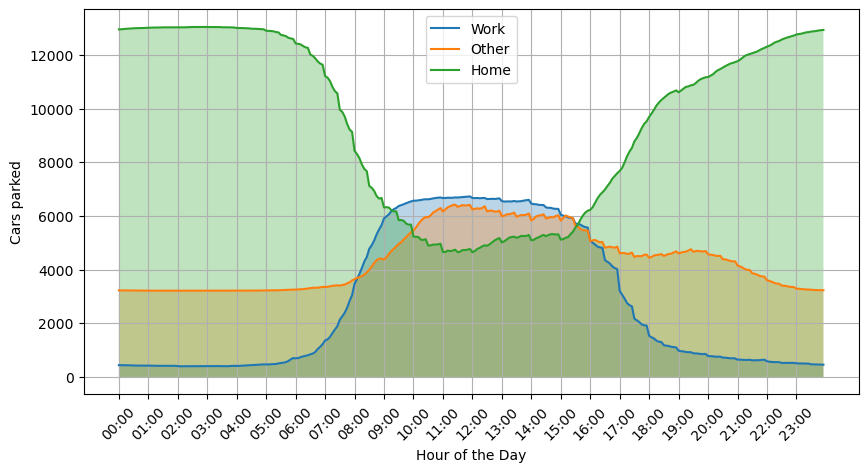

In [92]:
weekdays = list(range(1,5))
weekends = [6,7]

plt.figure(figsize=(10,5))

for i in range(1,4):
    plot_parking(i, parking_df, dow=weekdays)

plt.xticks(ticks=range(0, 288, 12), labels=time_labels[::12], rotation=45)
plt.grid()

plt.xlabel("Hour of the Day")
plt.ylabel("Cars parked")

plt.legend()

plt.savefig(plots_folder + "/Parking.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [22]:
len(parking_df)

93202

## Simulated EV demand

In [13]:
import EVforecaster.config as cfg
from EVforecaster.demand_curves import plot_weekly_demand

In [14]:
charging_df_path = cfg.root_folder + "/dataframes/charging_df.pkl"
plots_folder = cfg.root_folder + "/plots/"
charging_df = pd.read_pickle(charging_df_path)

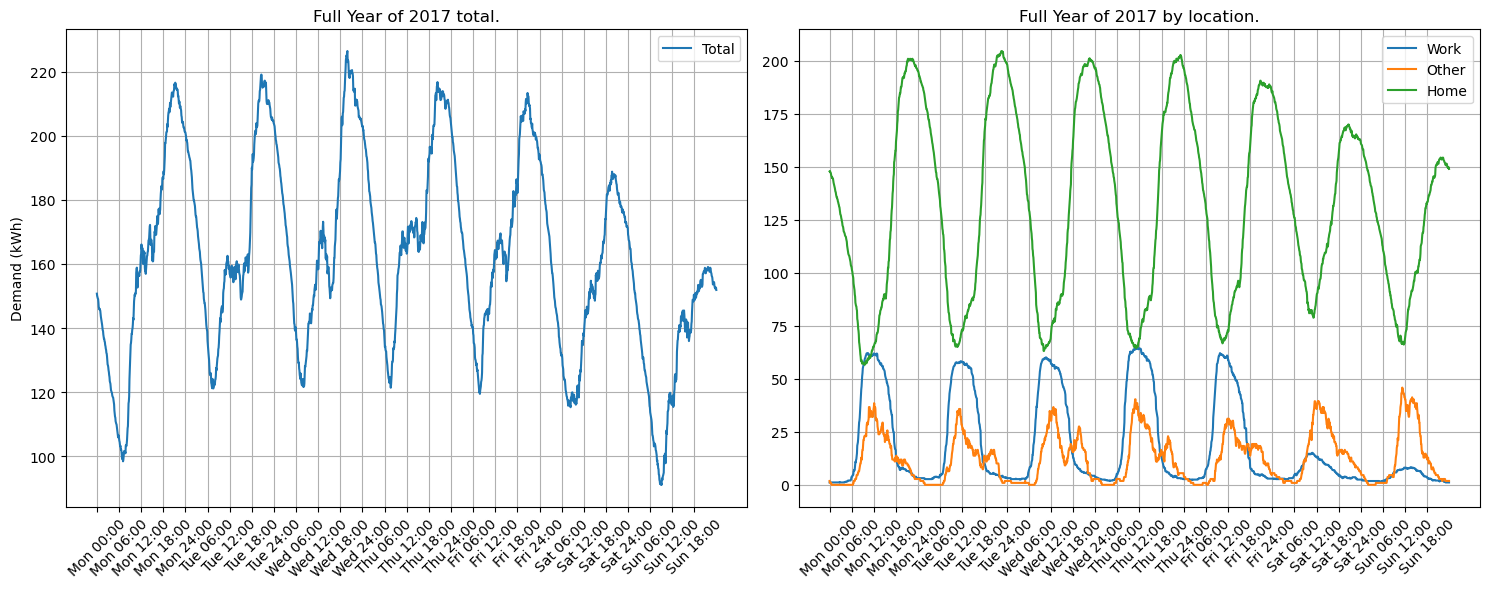

In [15]:
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_total", week_of_the_year=list(range(2,53)), week_label="Full Year", year_label=2017, save_fig=False)


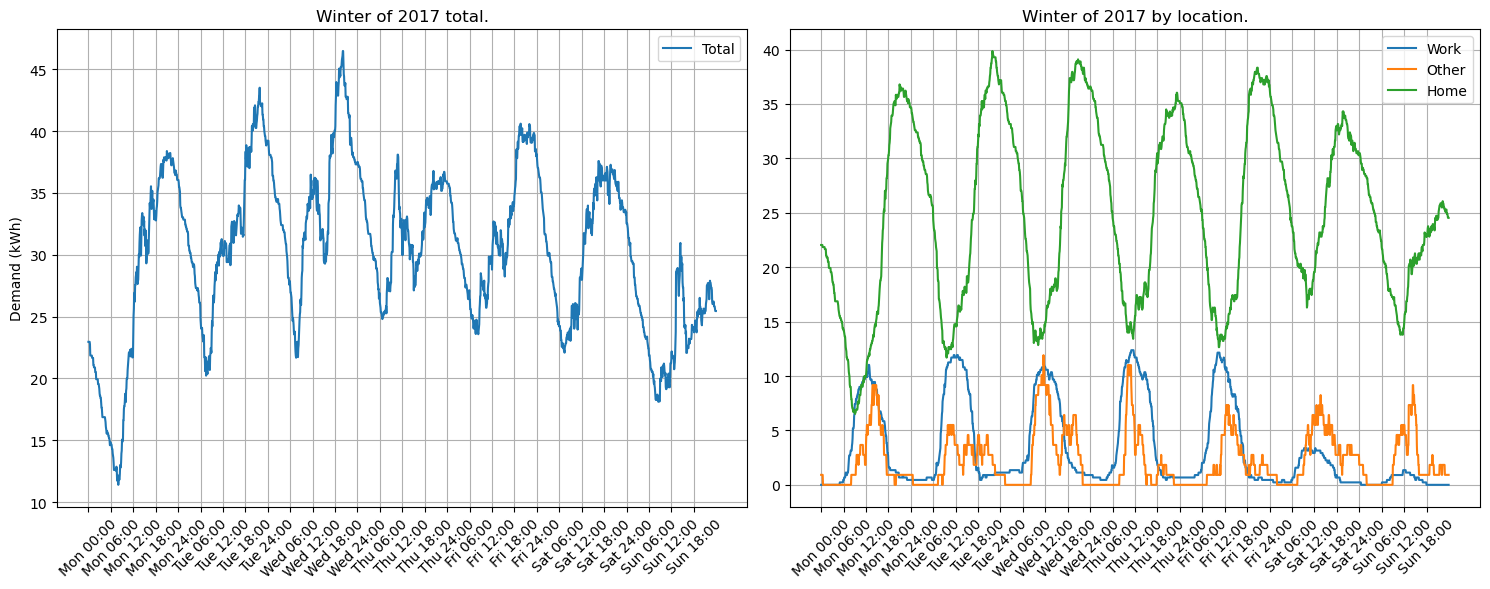

In [16]:
weeks_winter = [49,50,51,52] + list(range(1,10))
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_winter", week_of_the_year=weeks_winter, week_label="Winter", year_label=2017, save_fig=False)

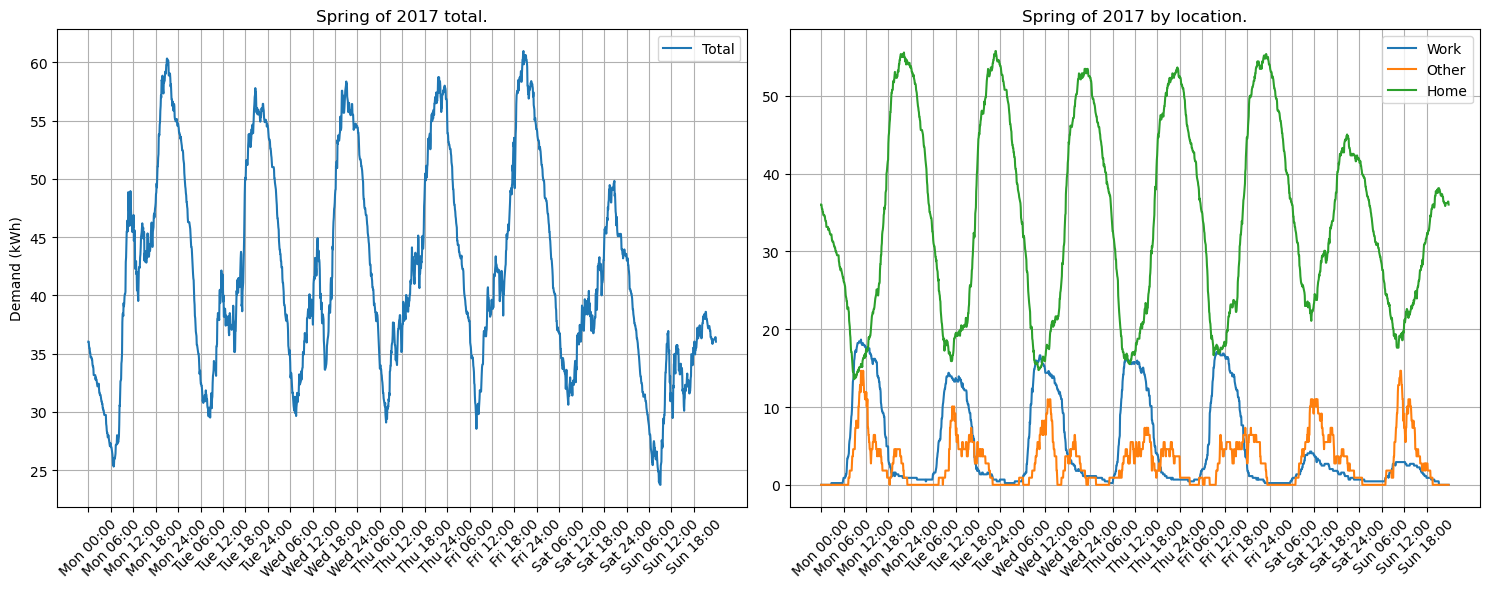

In [17]:
weeks_spring = list(range(10,22))
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_spring", week_of_the_year=weeks_spring, week_label="Spring", year_label=2017, save_fig=False)

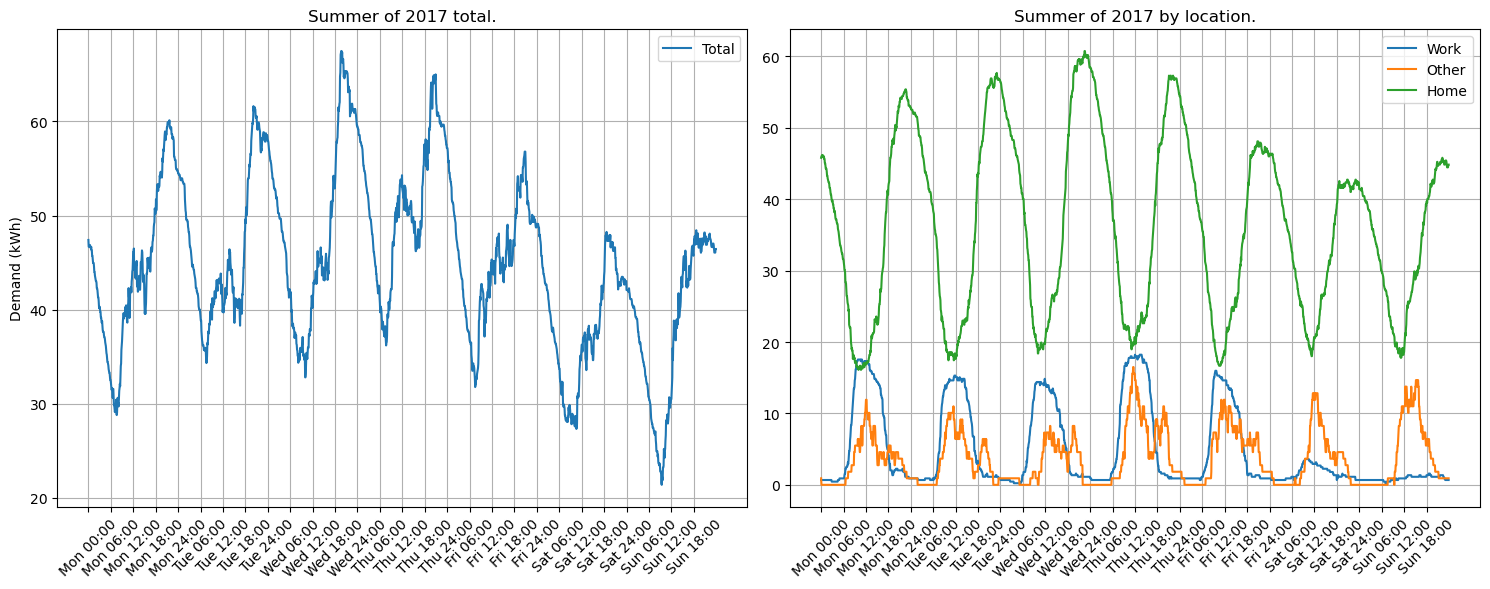

In [18]:
weeks_summer = list(range(22,36))
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_summer", week_of_the_year=weeks_summer, week_label="Summer", year_label=2017, save_fig=False)

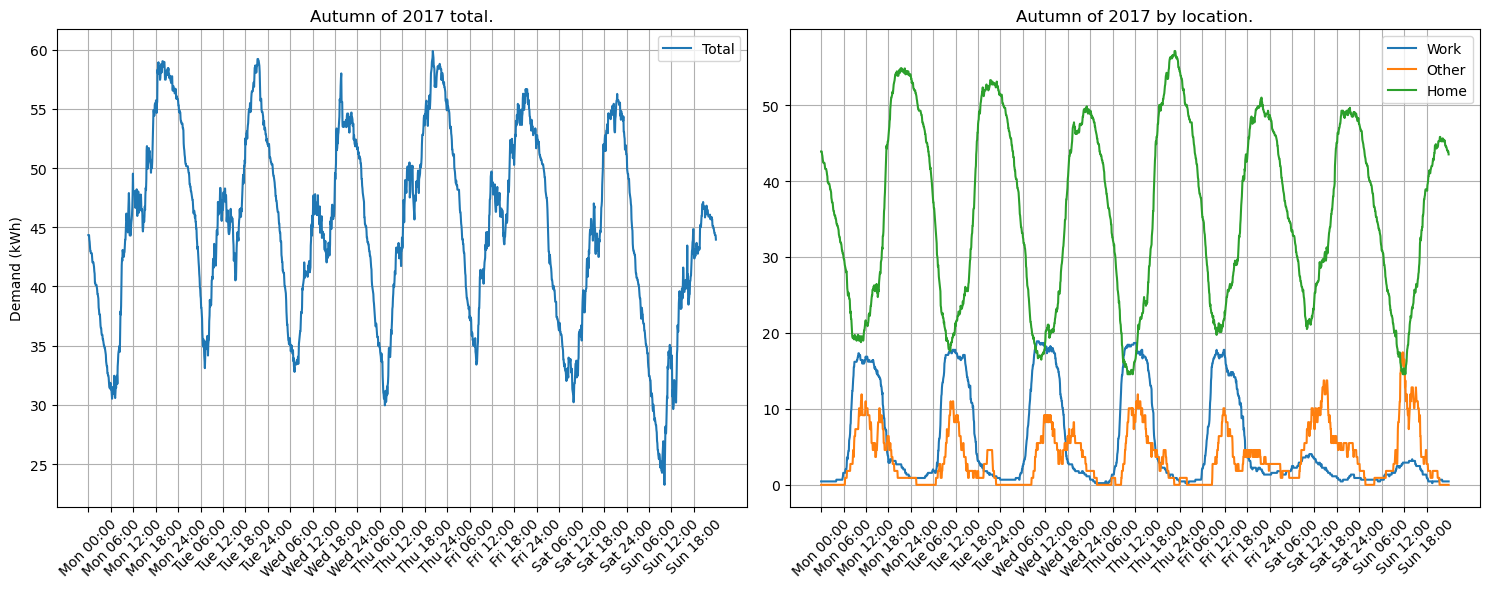

In [19]:
weeks_autumn = list(range(36,49))
plot_weekly_demand(charging_df=charging_df, output_file_name="plot_autumn", week_of_the_year=weeks_autumn, week_label="Autumn", year_label=2017, save_fig=False)